In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

train_dir = "/Users/oguzhanaydin/Downloads/chest_xray/train"
val_dir = "/Users/oguzhanaydin/Downloads/chest_xray/val"
test_dir = "/Users/oguzhanaydin/Downloads/chest_xray/test"

new_train_dir = "/Users/oguzhanaydin/Downloads/chest_xray/new_train"
new_val_dir = "/Users/oguzhanaydin/Downloads/chest_xray/new_val"

os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)

def get_image(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    images.append(file_path)
                    labels.append(label)
    return images, labels

train_images, train_labels = get_image(train_dir)
val_images, val_labels = get_image(val_dir)

all_images = train_images + val_images
all_labels = train_labels + val_labels

new_train_images, new_val_images, new_train_labels, new_val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

def copy_images_to_directory(image_paths, labels, target_directory):
    for img_path, label in zip(image_paths, labels):
        label_dir = os.path.join(target_directory, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, os.path.join(label_dir, os.path.basename(img_path)))

copy_images_to_directory(new_train_images, new_train_labels, new_train_dir)

copy_images_to_directory(new_val_images, new_val_labels, new_val_dir)

print(f"New training set size: {len(new_train_images)} images")
print(f"New validation set size: {len(new_val_images)} images")



New training set size: 4185 images
New validation set size: 1047 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [ ]:
train = image_generator.flow_from_directory(new_train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(new_val_dir,
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


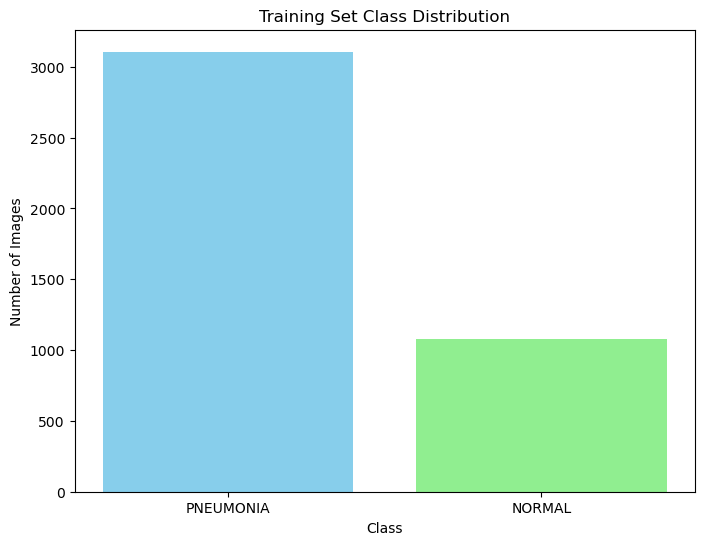

In [ ]:
pneumonia_dir = os.path.join(new_train_dir, 'PNEUMONIA')
normal_dir = os.path.join(new_train_dir, 'NORMAL')

num_pneumonia = len(os.listdir(pneumonia_dir))
num_normal = len(os.listdir(normal_dir))

labels = ['PNEUMONIA', 'NORMAL']
counts = [num_pneumonia, num_normal]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightgreen'])
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

Preventing Imbalance in data set

In [ ]:
adjusted_weight_for_0 = 1.9
adjusted_weight_for_1 = 0.6

class_weight = {0: adjusted_weight_for_0, 1: adjusted_weight_for_1}

print(f"Adjusted Weight for class 0 (PNEUMONIA): {adjusted_weight_for_0:.2f}")
print(f"Adjusted Weight for class 1 (NORMAL): {adjusted_weight_for_1:.2f}")


Adjusted Weight for class 0 (PNEUMONIA): 1.90
Adjusted Weight for class 1 (NORMAL): 0.60


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 340ms/step - accuracy: 0.6551 - loss: 4.0583 - val_accuracy: 0.0000e+00 - val_loss: 9.0086
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 359ms/step - accuracy: 0.8291 - loss: 0.3239 - val_accuracy: 0.0000e+00 - val_loss: 14.7927
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 340ms/step - accuracy: 0.8398 - loss: 0.3453 - val_accuracy: 0.0400 - val_loss: 4.3793
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 383ms/step - accuracy: 0.8813 - loss: 0.3231 - val_accuracy: 0.7200 - val_loss: 0.8263
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.8993 - loss: 0.2663 - val_accuracy: 0.8000 - val_loss: 0.5804
Epoch 6/10
 24/100 ━━━━━━━━━━━━━━━━━━━━ 27s 360ms/step - accuracy: 0.8386 - loss: 0.6071

2024-09-28 23:03:49.578996: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.8386 - loss: 0.4965 - val_accuracy: 0.9200 - val_loss: 0.2210
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 386ms/step - accuracy: 0.8571 - loss: 0.2803 - val_accuracy: 0.6800 - val_loss: 0.8782
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step - accuracy: 0.8769 - loss: 0.2565 - val_accuracy: 0.6400 - val_loss: 1.1689
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 363ms/step - accuracy: 0.8546 - loss: 0.4106 - val_accuracy: 0.3200 - val_loss: 7.1567
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step - accuracy: 0.8521 - loss: 0.5023 - val_accuracy: 0.9600 - val_loss: 0.2042


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
[[181  53]
 [ 49 341]]


,0,1,accuracy,macro avg,weighted avg
precision,0.786957,0.865482,0.836538,0.826219,0.836035
recall,0.773504,0.874359,0.836538,0.823932,0.836538
f1-score,0.780172,0.869898,0.836538,0.825035,0.836251
support,234.000000,390.000000,0.836538,624.000000,624.000000


Text(0.5, 1.0, 'Accuracy Evolution')

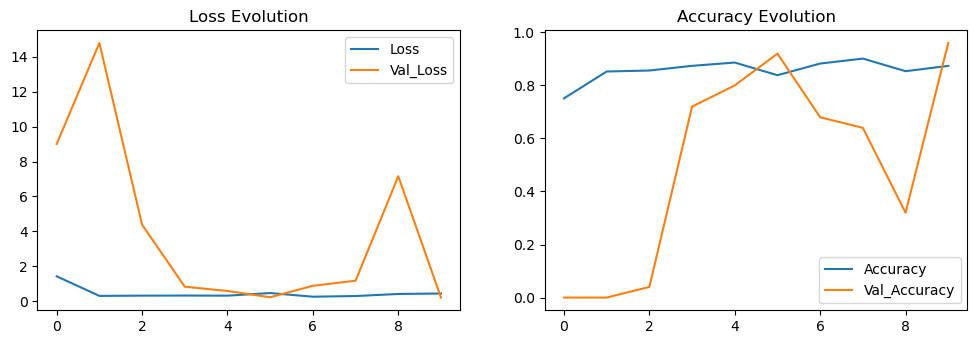

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.layers import GlobalAveragePooling2D

resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')

In [ ]:


resnet_model = tf.keras.Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)


In [ ]:
re = resnet_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 798ms/step - accuracy: 0.6703 - loss: 0.6474 - precision: 0.8579 - recall: 0.6766 - val_accuracy: 0.0000e+00 - val_loss: 345.7507 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 846ms/step - accuracy: 0.5605 - loss: 0.7448 - precision: 0.7914 - recall: 0.5417 - val_accuracy: 0.7600 - val_loss: 0.6454 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 91s 910ms/step - accuracy: 0.5922 - loss: 0.6690 - precision: 0.8222 - recall: 0.5397 - val_accuracy: 1.0000 - val_loss: 0.3174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 887ms/step - accuracy: 0.5778 - loss: 0.6677 - precision: 0.8382 - recall: 0.5490 - val_accuracy: 0.0000e+00 - val_loss: 4.0008 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 97s 974ms/step - accuracy: 0.5794 - loss: 0.6323 - precision: 0.84

/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 266ms/step - accuracy: 0.6204 - loss: 0.6101 - precision: 0.8013 - recall: 0.6013 - val_accuracy: 1.0000 - val_loss: 0.0307 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 992ms/step - accuracy: 0.5824 - loss: 0.5956 - precision: 0.8567 - recall: 0.5388 - val_accuracy: 0.9600 - val_loss: 0.2677 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 956ms/step - accuracy: 0.6107 - loss: 0.5815 - precision: 0.8816 - recall: 0.5656 - val_accuracy: 0.0000e+00 - val_loss: 2.3719 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6731 - loss: 0.4738 - precision: 0.9382 - recall: 0.6245 - val_accuracy: 1.0000 - val_loss: 0.0387 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7108 - loss: 0.4990 - precision: 0.9266 - recall: 0.6698

In [ ]:
pre = resnet_model.predict(test)

print(confusion_matrix(test.classes, pre > 0.5))
pd.DataFrame(classification_report(test.classes, pre > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step
[[  3 231]
 [  2 388]]


,0,1,accuracy,macro avg,weighted avg
precision,0.600000,0.626817,0.626603,0.613409,0.616761
recall,0.012821,0.994872,0.626603,0.503846,0.626603
f1-score,0.025105,0.769078,0.626603,0.397091,0.490088
support,234.000000,390.000000,0.626603,624.000000,624.000000


Text(0.5, 1.0, 'Accuracy Evolution')

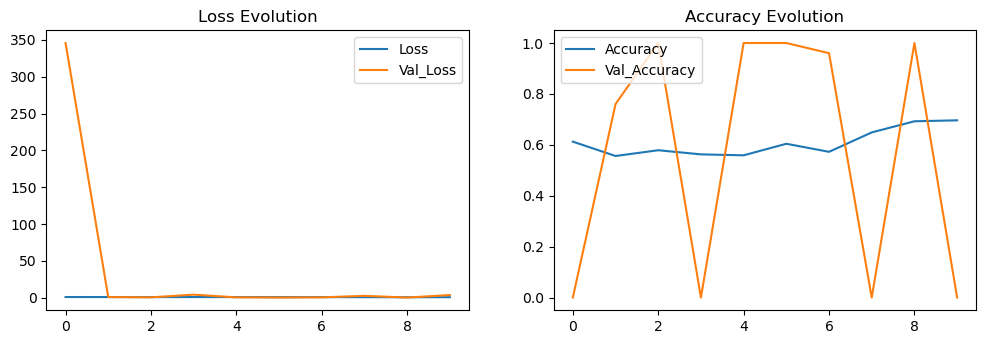

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(re.history['loss'], label='Loss')
plt.plot(re.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(re.history['accuracy'], label='Accuracy')
plt.plot(re.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 186, 186,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 90, 90,    │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 90, 90,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 90, 90,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 92, 92,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 45, 45,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 45, 45,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 45, 45,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 45, 45,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 45, 45,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 45, 45,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 45, 45,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 45, 45,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 45, 45,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 45, 45,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 45, 45,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

DenseNet121

In [ ]:
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
dn = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 91s 736ms/step - accuracy: 0.7444 - loss: 0.5963 - val_accuracy: 1.0000 - val_loss: 2.5050e-14
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 785ms/step - accuracy: 0.8894 - loss: 0.2752 - val_accuracy: 0.9200 - val_loss: 0.1665
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 786ms/step - accuracy: 0.8882 - loss: 0.2838 - val_accuracy: 0.9200 - val_loss: 0.1839
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 888ms/step - accuracy: 0.9267 - loss: 0.2025 - val_accuracy: 0.8400 - val_loss: 0.5575
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 862ms/step - accuracy: 0.8928 - loss: 0.2382 - val_accuracy: 1.0000 - val_loss: 0.0656
Epoch 6/10
 24/100 ━━━━━━━━━━━━━━━━━━━━ 59s 785ms/step - accuracy: 0.8900 - loss: 0.3373 

2024-09-29 12:27:18.526999: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.8905 - loss: 0.2953 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 779ms/step - accuracy: 0.8964 - loss: 0.1974 - val_accuracy: 0.9200 - val_loss: 0.1773
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 798ms/step - accuracy: 0.9119 - loss: 0.2110 - val_accuracy: 0.8000 - val_loss: 0.4221
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 754ms/step - accuracy: 0.9493 - loss: 0.1279 - val_accuracy: 0.9200 - val_loss: 0.3327
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 830ms/step - accuracy: 0.8544 - loss: 0.2717 - val_accuracy: 1.0000 - val_loss: 0.0255


In [ ]:
predc = model.predict(test)

print(confusion_matrix(test.classes, predc > 0.5))
pd.DataFrame(classification_report(test.classes, predc > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step
[[203  31]
 [ 21 369]]


,0,1,accuracy,macro avg,weighted avg
precision,0.906250,0.922500,0.916667,0.914375,0.916406
recall,0.867521,0.946154,0.916667,0.906838,0.916667
f1-score,0.886463,0.934177,0.916667,0.910320,0.916284
support,234.000000,390.000000,0.916667,624.000000,624.000000
